# 基于突变的模糊测试

## 随机生成测试用例的缺点

In [ ]:
from urllib.parse import urlparse

In [ ]:
urlparse("http://www.google.com/search?q=fuzzing")

In [ ]:
def http_program(url):
    """检查url的合法性"""
    supported_schemes = ["http","https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("url netloc must not be empty")
    return True

In [ ]:
def is_valid_url(url):
    try:
        http_program(url)
        return True
    except ValueError:
        return False

## 突变输入

In [ ]:
import random

In [ ]:
def delete_random_character(s):
    """在原字符串的基础上随机删除一个字符，并返回；原字符串不变"""
    if s == "":
        return s
    pos = random.randint(0,len(s)-1)
    return s[:pos] + s[pos+1:]

In [ ]:
def insert_random_character(s):
    """在原字符串的基础上随机插入一个字符，并返回；原字符串不变"""
    pos = random.randint(0,len(s)-1)
    # randint 左右闭区间，randrange左闭右开
    # randrange()功能相当于 choice(range(start, stop, step))
    random_char = chr(random.randrange(32,127)) 
    return s[:pos] + random_char + s[pos:]

In [ ]:
def flip_random_character(s):
    """在原字符串的基础上随机翻转一个bit，并返回；原字符串不变"""
    if s == "":
        return s
    pos = random.randint(0,len(s)-1)
    c = s[pos]
    bit = 1 << random.randint(0,6) # 注意这里只有七个位置可能翻转
    new_c = chr(ord(c)^bit)
    return  s[:pos] + new_c + s[pos+1:]

In [ ]:
def mutate(s):
    """随机选择一个突变方式"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    # print(type(mutators[0])) # 这里面存储的是函数类型，有意思
    matator = random.choice(mutators)
    return matator(s)

In [ ]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

## MutationFuzzer 代码

In [ ]:
from fuzzingbook.fuzzingbook_utils.Fuzzer import Fuzzer

In [ ]:
class MutationFuzzer(Fuzzer):
    def __init__(self,seed, min_mutations=2,max_mutations=10):
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()
    
    def reset(self):
        self.population = self.seed
        self.seed_index = 0
    
    def mutate(self,inp):
        return mutate(inp)
    
    # 从仓库中随机选择一个进行突变；
    # 仓库使用种子进行初始化（__init__中完成）
    # 这里并没有将突变生成的内容放入population
    def create_candidate(self):
        candidate = random.choice(self.population)
        trails = random.randint(self.min_mutations,self.max_mutations)
        for i in range(trails):
            candidate = self.mutate(candidate)
        return candidate
    
    def fuzz(self):
        if self.seed_index < len(self.seed):
            # 使用种子
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # 使用突变生成的内容
            self.inp = self.create_candidate()
        return self.inp
    


上面有个问题；突变的越多，生成种子的不合法性越大；如何控制突变呢？

## 覆盖率引导

In [33]:
from fuzzingbook.fuzzingbook_utils.Fuzzer import Runner
from fuzzingbook.fuzzingbook_utils.Coverage import Coverage,population_coverage

In [ ]:
class FunctionRunner(Runner):
    def __init__(self,function):
        self.function = function
    
    def run_function(self,inp):
        return self.function(inp)
    
    def run(self,inp):
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL
        return result,outcome

In [ ]:
http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar/")

In [ ]:
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self,inp):
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc
        self._coverage = cov.coverage()
        return result
    
    def coverage(self):
        return self._coverage

In [ ]:
http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")
print(list(http_runner.coverage())[:5])

In [30]:
class MutationCoverageFuzzer(MutationFuzzer):
    def reset(self):
        super().reset()
        self.coverages_seen = set()
        # Now empty; we fill this with seed in the first fuzz runs
        self.population = []

    def run(self, runner):
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            # We have new coverage
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)
    
        return result

In [31]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://www.go8gle.com/Search?Nq=fuzzIng',
 'http://www.go8gle.coOm/SearchNq=fuzIn',
 "http://www.go8'le.mSearch?Nq=fuzzIng",
 'http://www.go8ggle.#co/S4earch=?NqT=fuzJzng',
 'http://www.go8gle.rcomSearchNq~=fuzzKng',
 'htTp://wwwgto8gle.com/Search?F=FuzzIng',
 'http://www*.go8gle.ucom/Se.;arch?Nq=fuzzIg',
 'http://gww*.go8gle.}com/Se.;CarchNq=fuzzI',
 'hTtp://www.go8gle.rcomSearcNq~=fuzzKng',
 'hTtP://Www.go8gl.rcomSeavcNq~=fuzzKng',
 'hTtp://wwwg/:glez.rcomSe!rcNq~-fuMzzKng',
 'http://wJw.google.com/se;arch<a=uzzig',
 'http://www.go0gler.rcomSearchNq~=fuzzKng',
 'http://www*go8ggle.#co/S4arc`=?NqT?tfuzJzng',
 "http://wHww/go8Ugle.rComSearchN'q~=fuzzKng",
 'hTtp://wwg/:flez.rc#omSe!rcNq~-fuMzzKNe',
 'hTtp://wwg/:)lez.pcmmS%e!rcNq~-&umCzzKg',
 'htTp://gww*.go8gle.}c2om/Se.;CarchNq=fuzzI',
 'htTp://wwwgto8le*cowm/Searbh?FFuzzIng',
 'htTp://gww*.go8gle.=c2om/Se.;CarhNq=fuzzI',
 'http://ww.go8gle.goM/Seasch?Nq=f#tzzIn',
 'htTp://g#Ww*.go8gleJ.}c

In [34]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, http_program)

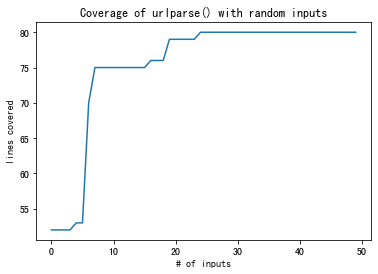

In [35]:
import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')